# Projet de scoring des clients d'une entreprise de télécommunication 

## Objectif 

Construire un modèle de scoring qui attribue à chaque client une probabilité de churn, afin de prioriser les actions de fidélisation sur les clients à haut risque. 

Commençons par importer les bibliothèques de base.  

In [1]:
# Import des bibliothèques 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

On peut charger le dataset 

In [2]:
# Import du fichier et chargement dans un dataframe

file_path = "C:/Users/HP PROBOOK/Desktop/Projet Scoring/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path) 

In [3]:
# Affichage du dataframe 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 1- Analyse exploratoire 

### 1-1 Nettoyage de la base 

Dans cette partie, nous allons procéder au néttoyage de notre base de données avec l'imputation des valeurs manquantes. Cependant, nous constatons que toutes les colonnes sont bien remplies, toutefois la colonne TotalCharges qui devrait être sous forme numérique float est plutôt sous forme object. Cela voudrait dire qu'elle contient des chaînes de caratères " ". Ce sont des cellules vide à cause de la variable tenure qui represente la durée du contrat en mois pour les nouveaux clients qui est égale à 0 et cela affecte donc directement la variable TotalCharges qui est le montant total facturé. 
Pour corriger ce problème, nous allons remplacer ces cellules vide par des NaN afin de les détecter comme des valeurs manquantes et les traiter. Pour le traitement, nous allons supprimer ces lignes car elles ne sont pas utiles pour notre prédiction. Ce sont des nouveau clients sans historiques de données. Ensuite, nous allons convertir la colonne en float et reindexer notre dataframe. 

Nous allons convertir aussi notre variable cible en variable numérique 

In [5]:
# Suppression des espaces
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Conversion de la variable cible
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Apperçu des variables 

In [6]:
print("Aperçu des données :")
print(df.head())

print("\nTypes de variables :")
print(df.dtypes)

print("\nValeurs manquantes :")
print(df.isnull().sum())


Aperçu des données :
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies

### 1-2 Statistiques descriptives des variables numériques

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


- La durée du contrat (tenure) des clients dans la base d'étude varie de 1-72 mois et le montant de facturation mensuelle (MonthlyCharges) quant à lui varie entre 18.25 et 118.75 dollars avec une moyenne de 64.79 dollars. 

- Le plus haut montant total facturé (TotalCharges) pour les clients est de 8684.4 dollars. Tandis que le plus faible est de 18.8 dollars. Cette variable est fonction de l'anciennété du client. En effet, plus le client est ancien et regulier dans le paiement de son abonnement mensuel, plus la variable TotalCharges est grande. 

### 1-3 Statistiques globale de la variable churn 


Distribution de la variable cible :
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


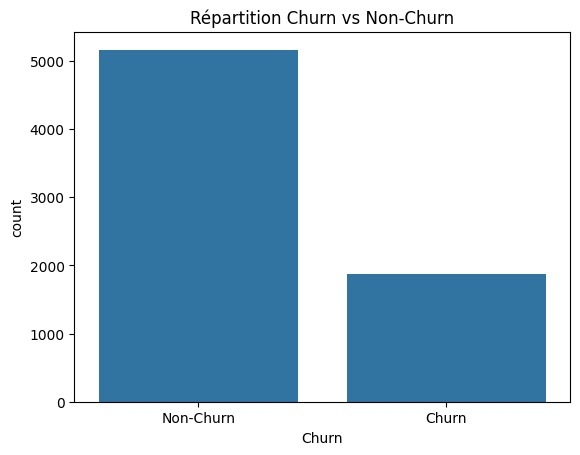

In [8]:
print("\nDistribution de la variable cible :")
print(df['Churn'].value_counts(normalize=True))

sns.countplot(x='Churn', data=df)
plt.title('Répartition Churn vs Non-Churn')
plt.xticks([0, 1], ['Non-Churn', 'Churn'])
plt.show()


26.58% des clients de notre base de données ont churné contre 73.42%. Certes, le nombre n'est pas trop élevé mais avec une abonne approche marketing grâce aux resultats du scoring, on peut reduire ce taux à 5%. 

### 1-4 Analyse des variables numériques 

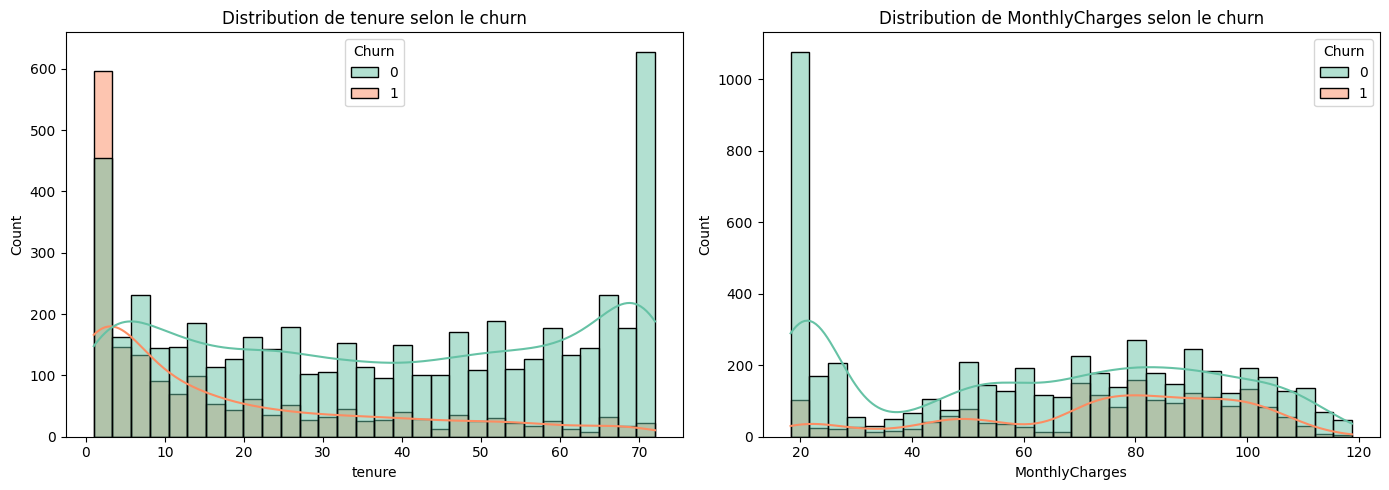

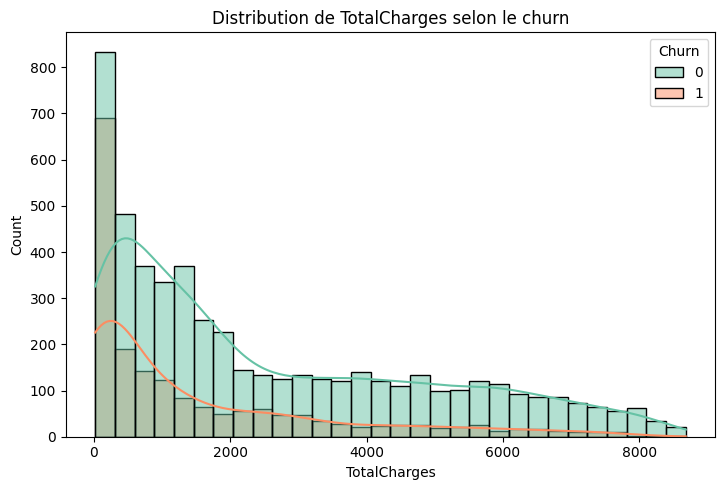

In [9]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Boucle par 2 variables à la fois
for i in range(0, len(num_cols), 2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for j in range(2):
        if i + j < len(num_cols):
            col = num_cols[i + j]
            sns.histplot(data=df, x=col, hue='Churn', bins=30, kde=True, ax=axes[j], palette='Set2')
            axes[j].set_title(f'Distribution de {col} selon le churn')
        else:
            fig.delaxes(axes[j])  # Supprimer l'axe vide si nombre impair

    plt.tight_layout()
    plt.show()

Le churn est beaucoup plus élevé chez les nouveaux abonnés. Alors que les plus anciens sont majoritairement plus fidèles. 

Actions marketing adaptées 
- Mettre en place une stratégie de suivi strict des nouveaux abonnés basée sur des rappels à deux semaines avant l'expiration des abonnements.

Les clients qui ont une facturation mensuelle compris entre 70 et 100 dollars sont ceux qui churnent le plus. 

Actions marketing adaptées 
- Proposer à cette cible des offres plus accessibles selon leur revenu. 

La variable TotalCharges étant dependante de l'ancienneté et de la facturation mensuelle, sa variation est donc naturellement liée aux comportements des clients observés au niveau des deux autres. Donc, pour les clients recents ayant un TotalCharges plus bas, le risque de churn est plus élevé.

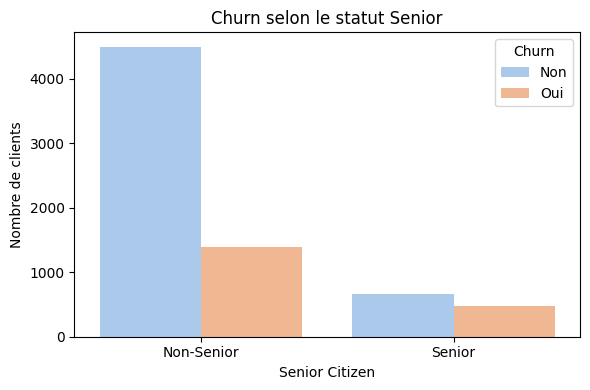

Taux de churn (%) selon le statut Senior :

SeniorCitizen
0    23.65
1    41.68
Name: Churn, dtype: float64


In [10]:
# Création du graphique
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='SeniorCitizen', hue='Churn', palette='pastel')

# Ajout des étiquettes
plt.title('Churn selon le statut Senior')
plt.xlabel('Senior Citizen')
plt.ylabel('Nombre de clients')
plt.xticks([0, 1], ['Non-Senior', 'Senior'])
plt.legend(title='Churn', labels=['Non', 'Oui'])
plt.tight_layout()
plt.show()

# Taux de churn selon statut senior
taux_churn_senior = df.groupby('SeniorCitizen')['Churn'].mean() * 100
print("Taux de churn (%) selon le statut Senior :\n")
print(taux_churn_senior.round(2))


### 1-5 Analyse des variables catégorielles

Avant tout, faisons un regroupement au niveau de certaines modalités afin de simplifier notre visualisation et faciliter aussi l'encodage après. 

In [11]:
# Colonnes concernées par "No internet service"
internet_related_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Colonnes concernées par "No phone service"
phone_related_cols = ['MultipleLines']

# Remplacement dans les colonnes liées à internet
for col in internet_related_cols:
    df[col] = df[col].replace({'No internet service': 'No'})

# Remplacement dans les colonnes liées au téléphone
for col in phone_related_cols:
    df[col] = df[col].replace({'No phone service': 'No'})


Vérification 

In [12]:
for col in internet_related_cols + phone_related_cols:
    print(f"{col} → {df[col].unique()}")


OnlineSecurity → ['No' 'Yes']
OnlineBackup → ['Yes' 'No']
DeviceProtection → ['No' 'Yes']
TechSupport → ['No' 'Yes']
StreamingTV → ['No' 'Yes']
StreamingMovies → ['No' 'Yes']
MultipleLines → ['No' 'Yes']


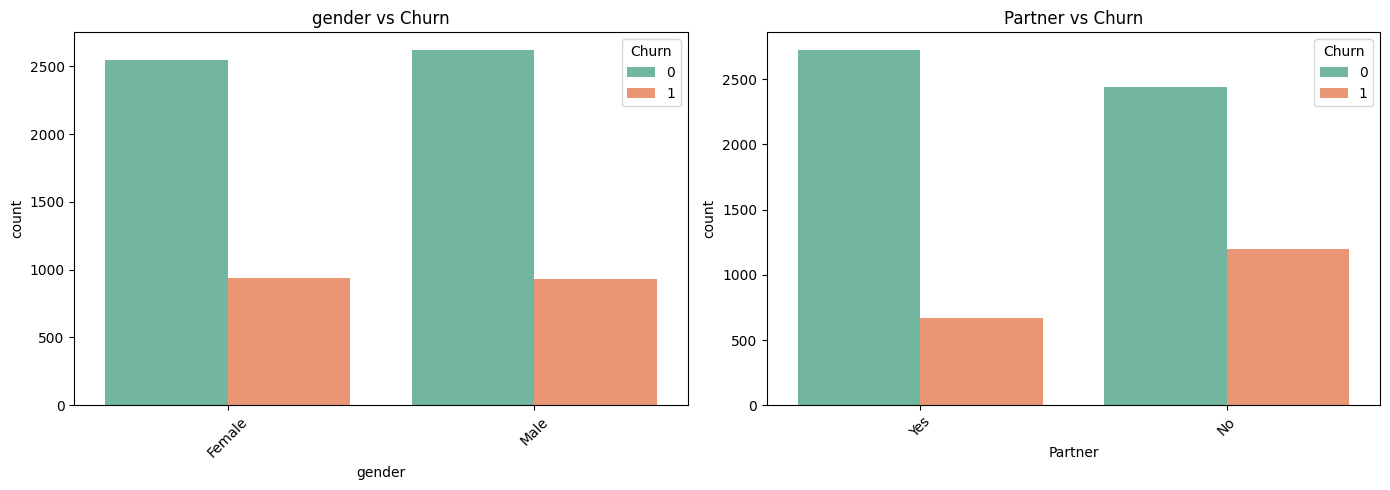

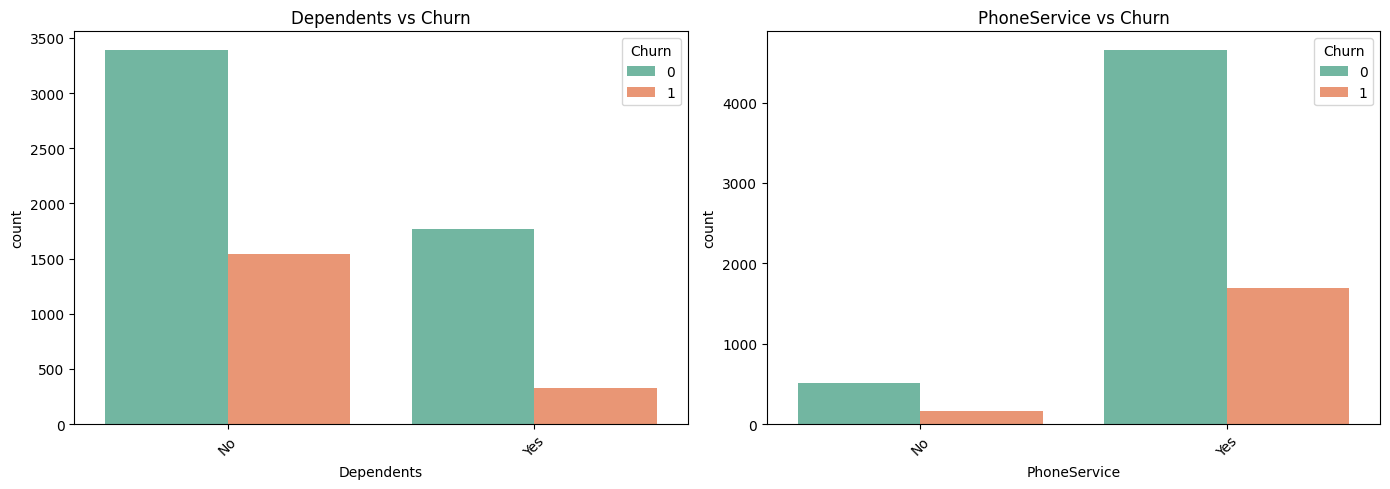

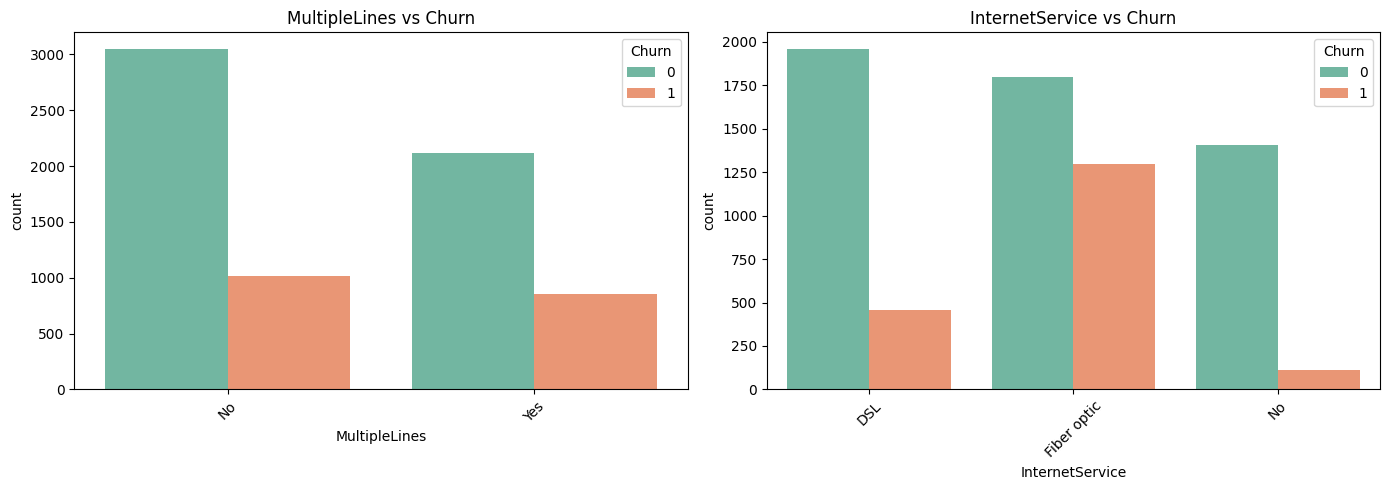

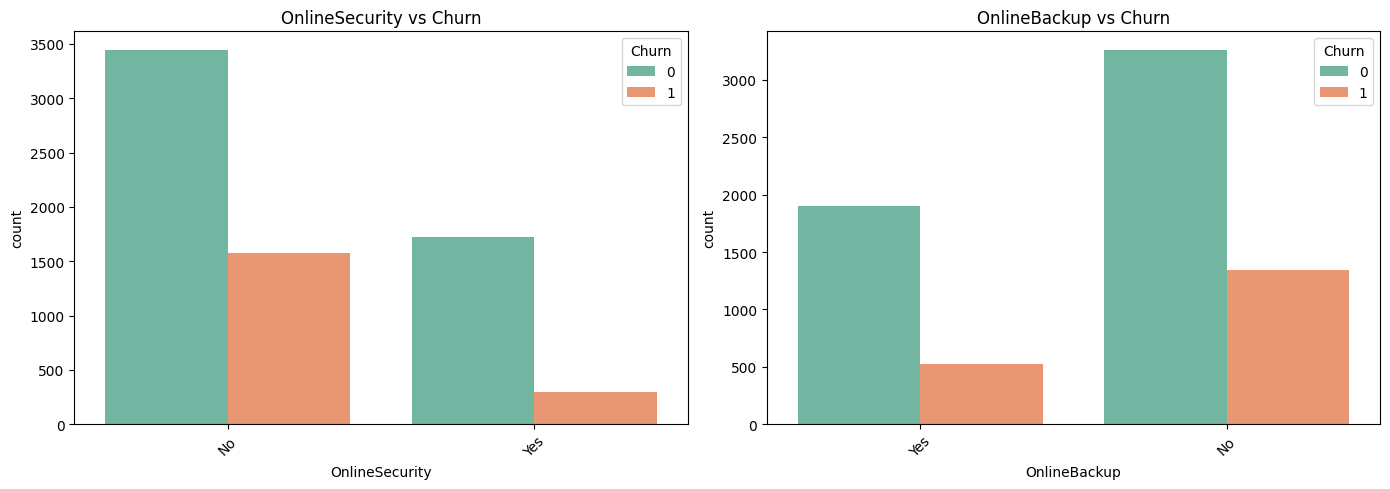

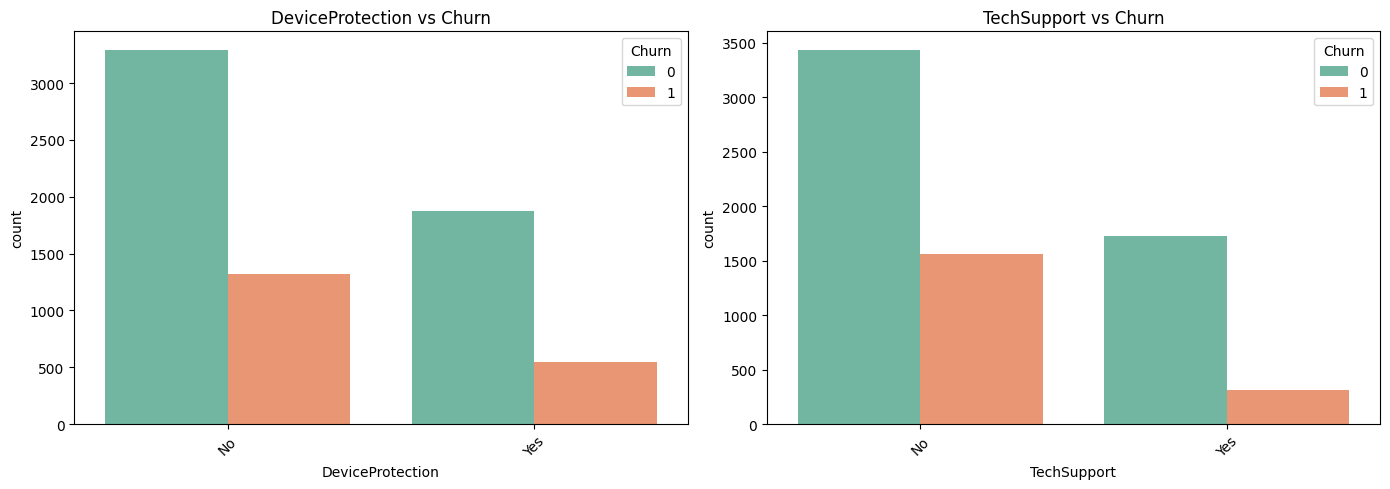

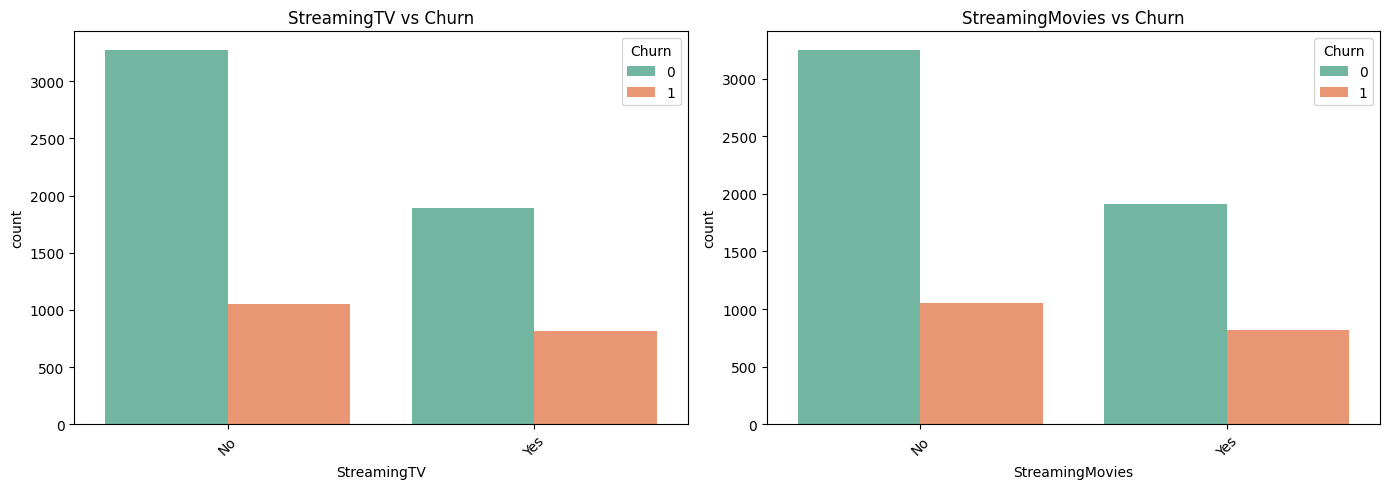

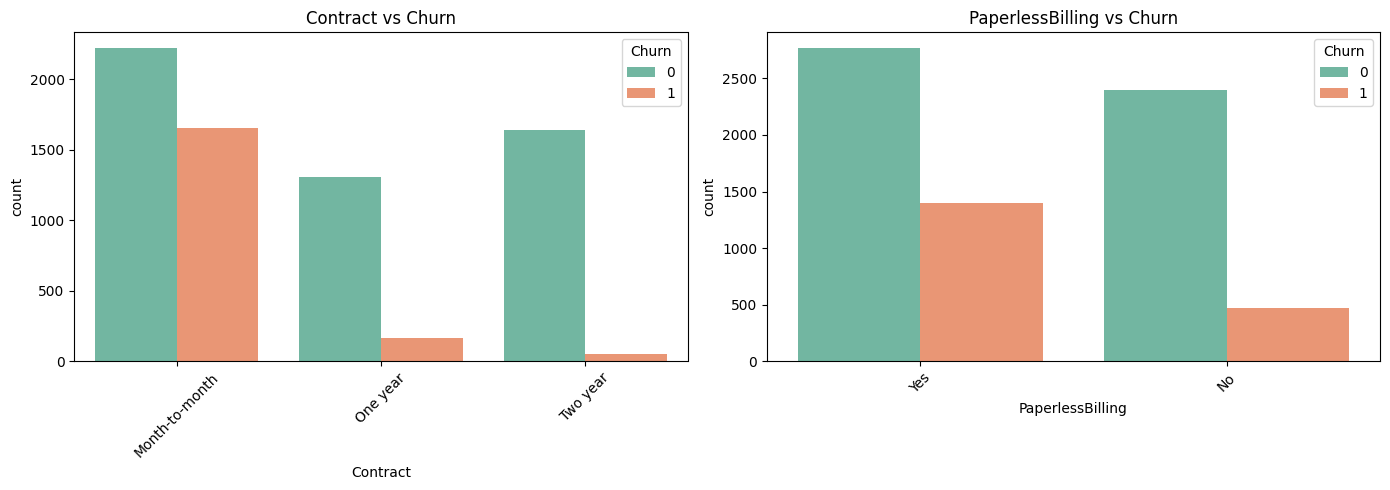

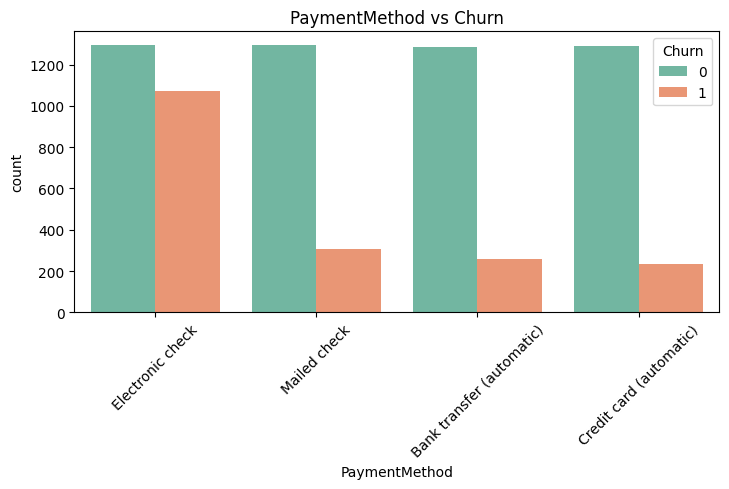

In [13]:
# Liste des colonnes catégorielles (hors ID et cible)
cat_cols = df.select_dtypes(include='object').columns.drop(['customerID'])

# Nombre de colonnes
n = len(cat_cols)

# Boucle pour afficher 2 plots par figure
for i in range(0, n, 2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 ligne, 2 colonnes

    for j in range(2):
        if i + j < n:
            col = cat_cols[i + j]
            sns.countplot(data=df, x=col, hue='Churn', ax=axes[j], palette='Set2')
            axes[j].set_title(f'{col} vs Churn')
            axes[j].tick_params(axis='x', rotation=45)
        else:
            fig.delaxes(axes[j])  # Supprimer l'axe vide si le nombre de colonnes est impair

    plt.tight_layout()
    plt.show()


Affichons le taux de churn par modalités 

In [14]:
cat_cols = df.select_dtypes(include='object').columns.drop(['customerID'])

for col in cat_cols:
    taux = df.groupby(col)['Churn'].mean().sort_values(ascending=False) * 100
    print(f"\n📌 Taux de churn par modalité de la variable '{col}' :")
    print(taux.round(2))



📌 Taux de churn par modalité de la variable 'gender' :
gender
Female    26.96
Male      26.20
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'Partner' :
Partner
No     32.98
Yes    19.72
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'Dependents' :
Dependents
No     31.28
Yes    15.53
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'PhoneService' :
PhoneService
Yes    26.75
No     25.00
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'MultipleLines' :
MultipleLines
Yes    28.65
No     25.07
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'InternetService' :
InternetService
Fiber optic    41.89
DSL            19.00
No              7.43
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'OnlineSecurity' :
OnlineSecurity
No     31.37
Yes    14.64
Name: Churn, dtype: float64

📌 Taux de churn par modalité de la variable 'OnlineBackup' :
Online

Le taux de churn au niveau des deux sexes est sensiblement égale. Ce qui veut dire que la variable gender n'est pas trop utile pour le churn. 

Les clients célibataires réalisent plus de churn que ceux qui sont en couple : 32.98% contre 19.72%. On peut comprendre, dans un couple les chargent sont souvent divisées tandis que le célibataire se rétrouve seul avec toutes les factures à gérer.    

Les clients qui disposent des personnes à leur charge ont un faible taux de churn (15.53%) comparé à ceux qui n'en possèdent pas (31.28%). On déduit que la présence des enfants dans une maison a d'impact sur la fidélité des clients à l'offre.

L'offre PhoneService n'influence pas trop la résiliation des abonnements par les clients. Le taux de churn est pratiquement égale dans les deuc cas : 26.75% pour Yes et 25.00% pour No.  

Les clients qui utilisent plusieurs lignes présentent un taux de churn un peu supérieur aux autres : 28.65% contre 25.07% 

L'utilisation de la fibre optique est un facteur très délicat pour le churn. La quasi majeure partie du churn concerne les clients qui utilisent ce type de service internet : 41.89%. Ceux qui utilisent le DSL font 19.00% et seulement 7.43% pour les abonnés qui n'utilisent pas du tout d'internet.

Les abonnés qui n'ont pas de service de sécurité en ligne résilient vite leur abonnement que les autres : 31.37% contre 14.64%. 

Les abonnés qui disposent d'un service de sauvégarde en ligne churnent moins (21.57%) que les autres (29.22%). 

La clients qui ne disposent pas de système de protection pour leurs divers appareils churnent le plus. Le taux est de  28.70% contre 22.54%. 

L'équipe marketing peut proposer un essai gratuit de ses services optionnels à ses genres d'abonnés pour espérer un changement positif. 

Le taux du churn des clients qui n'ont pas d'accès au support technique est deux fois plus élevé que ceux qui ont ce privilège : 31.33% contre 15.20%. On déduit alors que le support technique a un très grand impact sur le churn.   

Les abonnés qui n'ont pas d'accès à la StreamingTV ont un taux de churn plus faible (24.37%) par rapport à ceux qui l'ont (30.11%). Même constat avec la variable StreamingMovies. Cette remarque prouve qu'il y a probablement un souci de stabilté de la connexion internet qui frustre les streameurs et les poussent à churner. 

Le type de contrat influence beaucoup la fidélité des abonnés. Les clients avec les plus longs contrats resilient rarement leur abonnement. On a 2.85% pour les abonnés de deux ans et 11.28% pour les abonnés d'un an. Tandis que ceux qui préfèrent les abonnements mensuels ont churné avec un taux de 42.71%. Ce sont les clients à haut risque. 
L'équipe de marketing peut leur proposer offres exclusives pour les inciter à changer d'abonnement en passant à un an ou deux ans.  

Les clients qui reçoivent leurs factures sans papier présentent le double du taux de churn de ceux qui font le contraire : 33.59% pour Yes et 16.38% pour No. Donc, la disponibilité des factures en version papier est très importante pour fidéliser beaucoup de clients.  

Les moyens de paiements automatiques avec les cartes de crédits et les transferts bancaires facilitent la tâche aux abonnés. Mais ceux qui utilisent d'autres sytèmes électroniques rencontrent certainement des problèmes ou oublient de renouveller et abandonnent volontairement le service. En effet, les taux de churn sont de : 
Electronic check             45.29
Mailed check                 19.20
Bank transfer (automatic)    16.73
Credit card (automatic)      15.25

Il faut vite leur recommander un moyen de paiement auto. 

En résumé, on peut déduire le profil du client à haut risque avec les caractériques suivantes : 

- Un abonné recent ;
- Avec une facturation mensuelle compris entre 70 et 100 dollars ;
- Célibataire et sans aucune autre charge à sa disposition à la maison ; 
- Utilise la fibre optique ;
- Pas de service de securité en ligne ;
- Pas d'accès au support technique ;
- Fais le streaming ;
- Reçois ses factures sans papier ;
- Dispose d'un contrat mensuel ;
- Pas de moyen de paiement automatique. 

## 2- Modélisation 

### 2-1 Feature engineering 

Nous allons créer de nouvelles variables afin de mieux enrichir la performance de notre modèle 

In [15]:
# Moyenne mensuelle rélle dépensée (division par 0 à éviter)
df['AvgMonthlySpent'] = df['TotalCharges'] / df['tenure'].replace(0, np.nan)

# Vie de famille : En couple ou personnes à charges 
df['IsFamily'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)

# Paiement automatique 
df['IsAutoPay'] = df['PaymentMethod'].str.lower().str.contains('automatic').astype(int)

# Client à risque 
df['IsAtRiskClient'] = (
    (df['tenure'] < 6) &
    (df['MonthlyCharges'] > 70) &
    (df['Contract'] == 'Month-to-month')
).astype(int)

# Nombre total de services souscrits 
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Chaque service = 1 si "Yes", 0 sinon 
df['NbServices'] = df[service_cols].apply(lambda row: sum(val == 'Yes' for val in row), axis=1)

# Possède au moins un service streaming 
df['HasStreaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)

# Utilise la fibre optique 
df['IsFiberOpticUser'] = (df['InternetService'] == 'Fiber optic').astype(int)

# Groupe d'anciennté : Création d'une variable catégorielle avec des tranches
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 6, 12, 24, df['tenure'].max()],
                           labels=['0-6 mois', '6-12 mois', '12-24 mois', '24+ mois'])

Affichons le dataset actualisé 

In [16]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TotalCharges,Churn,AvgMonthlySpent,IsFamily,IsAutoPay,IsAtRiskClient,NbServices,HasStreaming,IsFiberOpticUser,TenureGroup
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,29.85,0,29.850000,1,0,0,1,0,0,0-6 mois
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,1889.50,0,55.573529,0,0,0,3,0,0,24+ mois
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,108.15,1,54.075000,0,0,0,3,0,0,0-6 mois
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,1840.75,0,40.905556,0,1,0,3,0,0,24+ mois
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,151.65,1,75.825000,0,0,1,1,0,1,0-6 mois


## 2-2 Sélection de variables 

- Utilisons la matrice de correlation pour identifier les variables numériques et le churn  

In [17]:
# Mise à jours de num_cols
num_cols_maj = num_cols + ['AvgMonthlySpent', 'IsFamily', 'IsAutoPay', 'IsAtRiskClient', 'NbServices', 'HasStreaming', 'IsFiberOpticUser',  ]

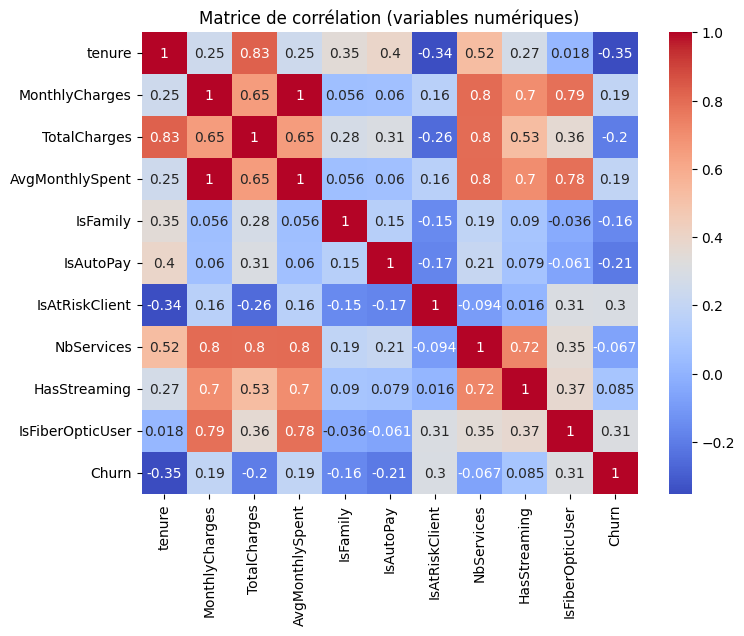

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols_maj + ['Churn']].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation (variables numériques)')
plt.show() 

- Les variables MonthlyCharges et AvgMonthlySpent sont très corrélée (1) entre elles. Nous allons supprimer l'une des deux, soit AvgMonthlySpent, étant donné que c'est elle la nouvelle qui s'est ajoutée à la liste après le feature engineering. 

- La variable TotalCharges est fortement corrélée avec la variable tenure (0.83). Elle est encore un peu corrélée avec Nbservices (0.8). Donc, compte tenu des rémarques au niveau de l'analyse exploratoire, nous pouvons la supprimer aussi. 

In [19]:
# Suppression des variables redondantes
df.drop(columns=['AvgMonthlySpent', 'TotalCharges'], inplace=True) 

- Encodage des variables catégorielles 

In [20]:
from sklearn.preprocessing import LabelEncoder

# 1. Encodage LabelEncoder pour les colonnes binaires
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# 2. Ajout de la variable 'TenureGroup' aux colonnes catégorielles à encoder en one-hot
cat_cols = ['InternetService', 'Contract', 'PaymentMethod', 'TenureGroup']

# 3. Encodage one-hot
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Suppression de la variable customerID et conversion des colonnes boléennes en binaire 

In [21]:
# Supprimer la colonne des ID 
df = df.drop('customerID', axis=1)

In [22]:
# Convertir les colonnes de type booléen en entiers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [23]:
# Vérification 
print(df.dtypes.value_counts())

int64      31
float64     1
Name: count, dtype: int64


Passons à présent à la sélection avec SelectKBest

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

# Séparation des variables explicatives et de la cible
X = df.drop('Churn', axis=1)
y = df['Churn']

# Sélection des k meilleures variables (par exemple 15)
k = 20
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Récupérer les noms des variables sélectionnées
selected_features = X.columns[selector.get_support()]

print("Variables sélectionnées :")
print(selected_features)

Variables sélectionnées :
Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
       'TechSupport', 'PaperlessBilling', 'MonthlyCharges', 'IsFamily',
       'IsAutoPay', 'IsAtRiskClient', 'IsFiberOpticUser',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'TenureGroup_24+ mois'],
      dtype='object')


## 2-3 Séparation en train et test et standardisation 

In [25]:
# Séparation des features et de la cible 
X = df.drop('Churn', axis=1)
y = df['Churn'] 

# Séparation en train et test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 80% train, 20% test
    random_state=42,      # pour reproductibilité
    stratify=y            # conserve la proportion de churn/non-churn
)


In [26]:
# Recupération des variables numériques dans la base X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Appliquons la standardisation 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Appliquer uniquement sur les colonnes numériques
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols]) 

## 2-4 Pipeline de préprocessing avec l'entrainement et evaluation des modèles


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      

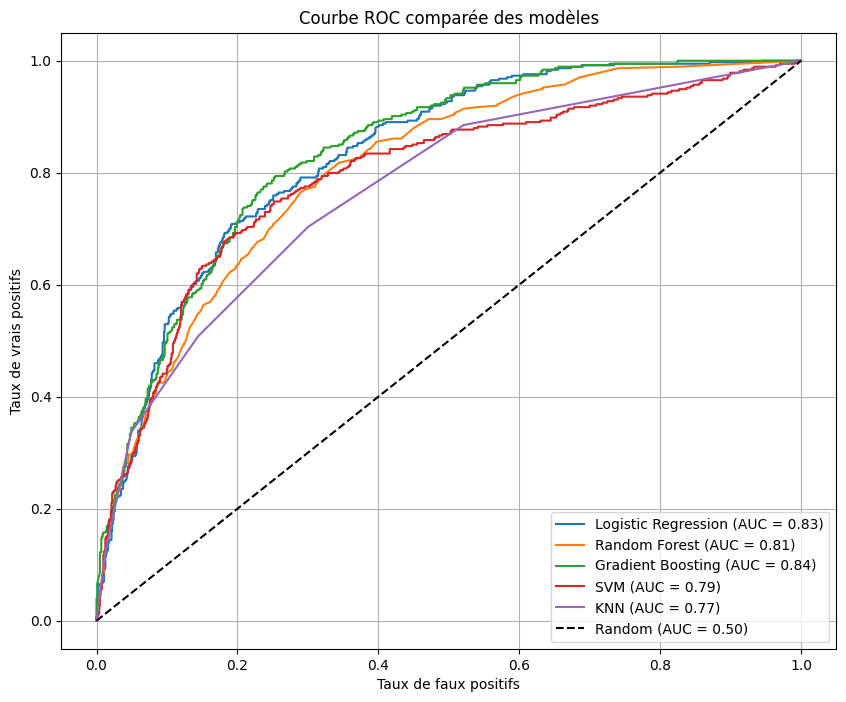

In [27]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Séparation de la cible et des features
X = df.drop(columns=['Churn'])
y = df['Churn']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Détection des variables numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Prétraitement
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Définir les modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

# Initialisation de la figure pour les courbes ROC
plt.figure(figsize=(10, 8))
roc_results = []

# Boucle d'entraînement et d'évaluation
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('selectkbest', SelectKBest(score_func=f_classif, k=20)),
        ('classifier', model)
    ])
    
    # Entraînement
    pipe.fit(X_train, y_train)
    
    # Prédictions
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Rapport de classification
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_results.append((name, roc_auc))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Courbe de référence aléatoire
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.title("Courbe ROC comparée des modèles")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid()
plt.show()


En nous référant sur les scores de l'AUC, on retient le gradient boosting comme meilleur modèle. Nous pouvons commencer notre scoring avec avec ce modèle. 

Pour cela, nous reprenons tout le processus avec un pipeline intégrant toutes les étapes 

C:\Users\HP PROBOOK\AppData\Local\Temp\ipykernel_14516\503274035.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


      customerID  Churn_Probabilité Risque_Churn
185   1024-GUALD           0.702302         Haut
1807  6910-HADCM           0.879453         Haut
6179  6328-ZPBGN           0.761870         Haut
4640  1853-UDXBW           0.803683         Haut
3328  1640-PLFMP           0.812000         Haut


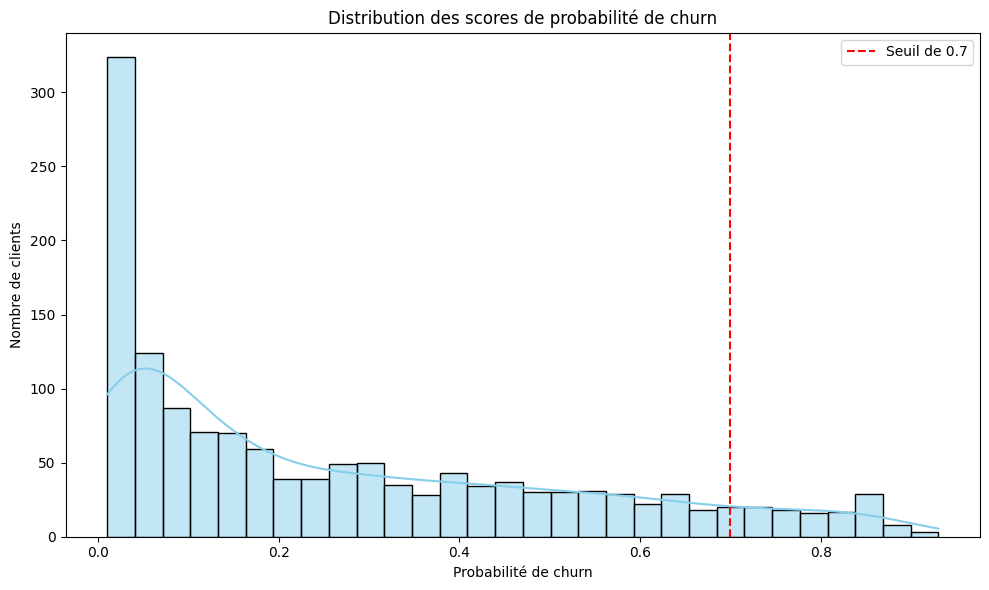

In [28]:
# 1. Recharger le dataset propre AVEC customerID et Churn
df = pd.read_csv("C:/Users/HP PROBOOK/Desktop/Projet Scoring/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df.copy()  # pour éviter les effets de bord

# 2. (Re)créer la colonne IsFamily si elle est utile
df['IsFamily'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)

# 3. Transformation de la colonne 'TotalCharges' si nécessaire
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 4. Cible binaire : 1 = Churn, 0 = Non churn
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 5. On garde customerID à part
customer_ids = df['customerID']

# 6. On définit X et y
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

# 7. Détecter types de colonnes
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 8. Pipeline de prétraitement
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# 9. Pipeline complet avec Gradient Boosting
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# 10. Séparation des données
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.2, random_state=42)

# 11. Entraînement du modèle
pipeline.fit(X_train, y_train)

# 12. Prédictions de probabilité sur X_test
probas = pipeline.predict_proba(X_test)[:, 1]  # Probabilité de churn (classe 1)

# 13. Création du DataFrame de résultats
resultats = pd.DataFrame({
    'customerID': id_test,
    'Churn_Probabilité': probas
})
resultats['Risque_Churn'] = resultats['Churn_Probabilité'].apply(lambda x: 'Haut' if x >= 0.7 else 'Faible')

# 14. Affichage des clients à haut risque
clients_à_risque = resultats[resultats['Risque_Churn'] == 'Haut']
print(clients_à_risque.head())

# 15. Visualisation
plt.figure(figsize=(10, 6))
sns.histplot(resultats['Churn_Probabilité'], bins=30, kde=True, color='skyblue')
plt.axvline(0.7, color='red', linestyle='--', label='Seuil de 0.7')
plt.title("Distribution des scores de probabilité de churn")
plt.xlabel("Probabilité de churn")
plt.ylabel("Nombre de clients")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
print(clients_à_risque)

      customerID  Churn_Probabilité Risque_Churn
185   1024-GUALD           0.702302         Haut
1807  6910-HADCM           0.879453         Haut
6179  6328-ZPBGN           0.761870         Haut
4640  1853-UDXBW           0.803683         Haut
3328  1640-PLFMP           0.812000         Haut
...          ...                ...          ...
1371  6567-HOOPW           0.864437         Haut
5872  4550-EVXNY           0.847818         Haut
2453  1197-BVMVG           0.777793         Haut
926   7074-IEVOJ           0.742224         Haut
5481  8473-VUVJN           0.857141         Haut

[123 rows x 3 columns]


Déterminons le pourcentage des clients à risque dans notre jeu de test 

In [30]:
pourcentage_risque = len(clients_à_risque) / len(X_test) * 100
print(f"Pourcentage de clients à risque dans le jeu de test : {pourcentage_risque:.2f}%")

Pourcentage de clients à risque dans le jeu de test : 8.73%


Visualisation avec un graphique en cercle 

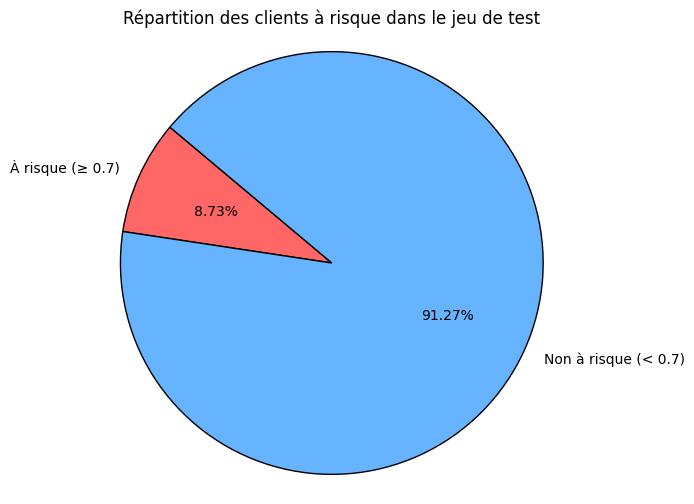

In [31]:
# Nombre total et à risque
total_clients = len(X_test)
clients_à_risque_test = (probas >= 0.7).sum()
clients_non_risque = total_clients - clients_à_risque_test

# 📊 Option 1 : Camembert
labels = ['À risque (≥ 0.7)', 'Non à risque (< 0.7)']
sizes = [clients_à_risque_test, clients_non_risque]
colors = ['#ff6666', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Répartition des clients à risque dans le jeu de test")
plt.axis('equal')  # cercle parfait
plt.show()

Reprenons le processus sur l'ensemble du dataset 

📌 Pourcentage de clients à haut risque dans tout le dataset : 8.02% (565 sur 7043)


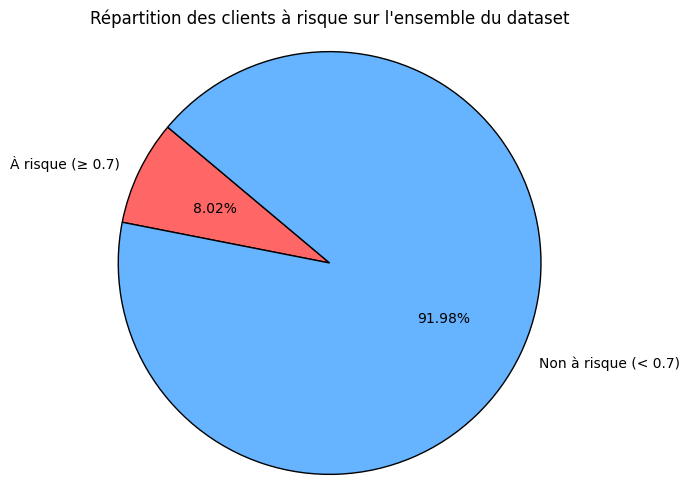

In [32]:
# 1. Prédiction des probabilités de churn pour tout le dataset
probas_all = pipeline.predict_proba(X)[:, 1]  # proba d'appartenir à la classe 1 (churn)

# 2. Création d'un DataFrame résultats
resultats_all = pd.DataFrame({
    'customerID': customer_ids,
    'Churn_Probabilité': probas_all
})
resultats_all['Risque_Churn'] = resultats_all['Churn_Probabilité'].apply(lambda x: 'Haut' if x >= 0.7 else 'Faible')

# 3. Calcul des statistiques
total_clients_all = len(X)
clients_à_risque_all = (probas_all >= 0.7).sum()
clients_non_risque_all = total_clients_all - clients_à_risque_all

# 4. Affichage du pourcentage
pourcentage_all = clients_à_risque_all / total_clients_all * 100
print(f"📌 Pourcentage de clients à haut risque dans tout le dataset : {pourcentage_all:.2f}% ({clients_à_risque_all} sur {total_clients_all})")

# 5. Camembert
labels_all = ['À risque (≥ 0.7)', 'Non à risque (< 0.7)']
sizes_all = [clients_à_risque_all, clients_non_risque_all]
colors = ['#ff6666', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(sizes_all, labels=labels_all, colors=colors, autopct='%.2f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Répartition des clients à risque sur l'ensemble du dataset")
plt.axis('equal')  # cercle parfait
plt.show()


Visualisation de l'importance des variables avec shap 

c:\Users\HP PROBOOK\Desktop\Projet Scoring\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


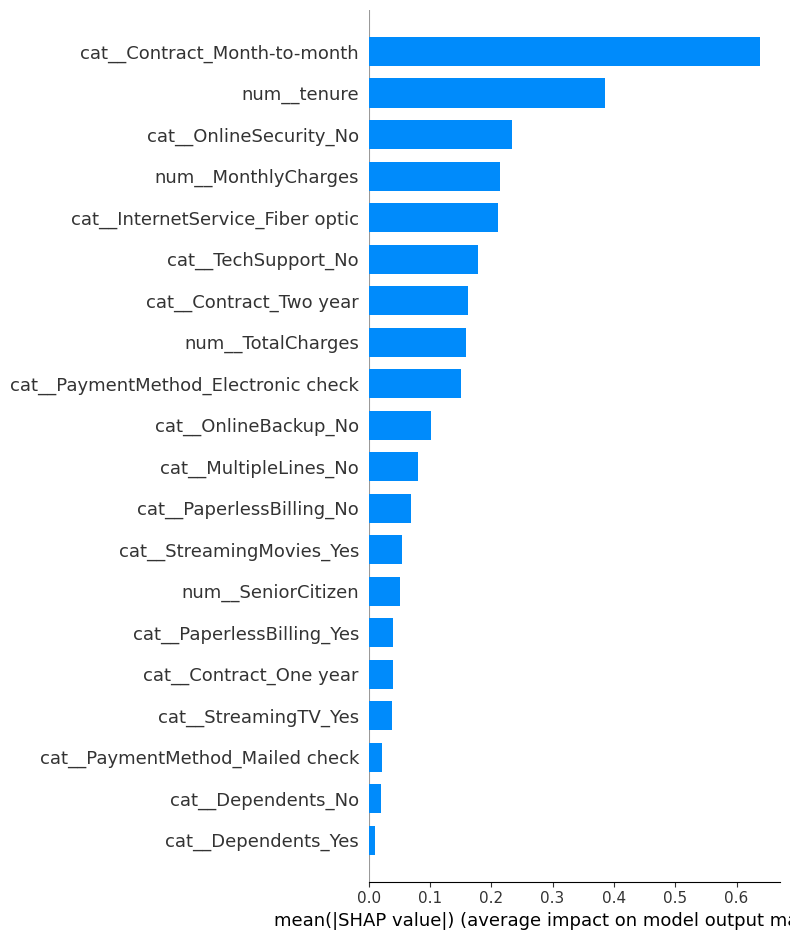

In [ ]:
import shap

# Étape 1 : Prétraitement des données 
X_transformed = preprocessor.fit_transform(X)  

# Étape 2 : Réentraînement du modèle hors pipeline (car SHAP nécessite un accès direct au modèle et aux features transformées)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_transformed, y)

# Étape 3 : Explicabilité avec SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_transformed)

# Étape 4 : Affichage des variables les plus importantes
plt.figure()
shap.summary_plot(shap_values, X_transformed, feature_names=preprocessor.get_feature_names_out(), plot_type="bar")

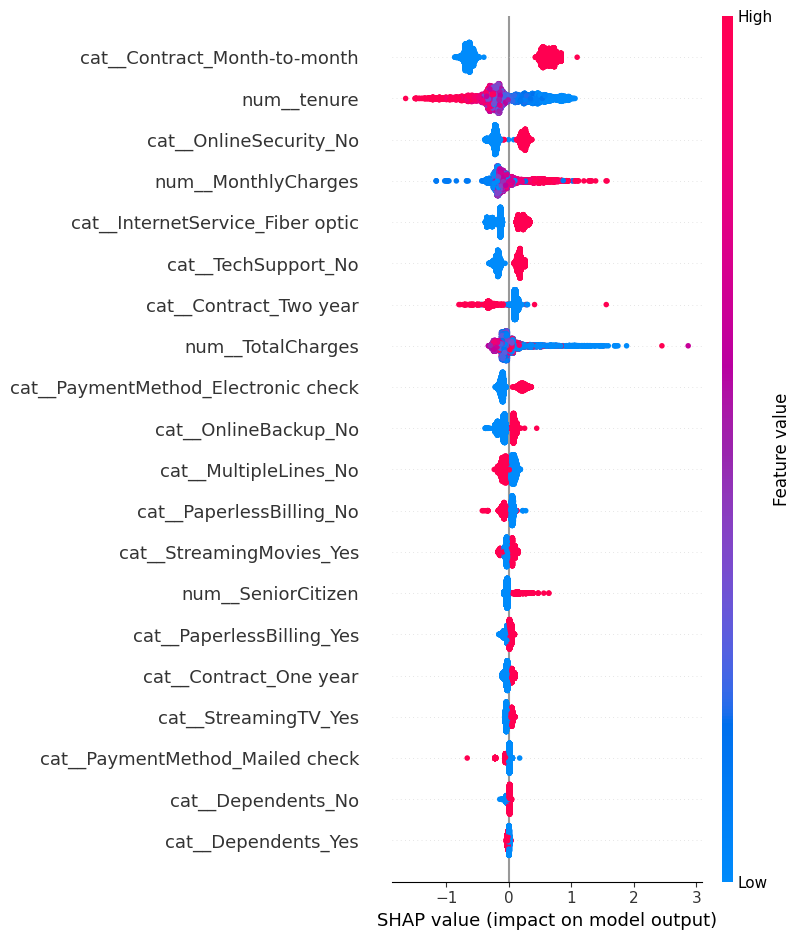

In [ ]:
# Pour voir l’impact détaillé de chaque variable sur les prédictions
shap.summary_plot(shap_values, X_transformed, feature_names=preprocessor.get_feature_names_out())

Exportation en csv de tous les profils à haut risque avec les actions marketing recommandées 

In [33]:
# 1. Ajout de la colonne d'action recommandée
def recommander_action(risque):
    if risque == 'Haut':
        return "Offre de fidélisation personnalisée"
    else:
        return "Continuer le suivi régulier"

resultats_all['Action_Marketing'] = resultats_all['Risque_Churn'].apply(recommander_action)

# 2. Exportation du fichier complet
resultats_all.to_csv("scoring_clients_avec_actions.csv", index=False)
print("✅ Fichier 'scoring_clients_avec_actions.csv' exporté avec succès.")

✅ Fichier 'scoring_clients_avec_actions.csv' exporté avec succès.


In [34]:
df_all_profils_risque = pd.read_csv("C:/Users/HP PROBOOK/Desktop/Projet Scoring/scoring_clients_avec_actions.csv")

In [35]:
df_all_profils_risque

,customerID,Churn_Probabilité,Risque_Churn,Action_Marketing
0,7590-VHVEG,0.457794,Faible,Continuer le suivi régulier
1,5575-GNVDE,0.048348,Faible,Continuer le suivi régulier
2,3668-QPYBK,0.270169,Faible,Continuer le suivi régulier
3,7795-CFOCW,0.052534,Faible,Continuer le suivi régulier
4,9237-HQITU,0.694621,Faible,Continuer le suivi régulier
...,...,...,...,...
7038,6840-RESVB,0.087193,Faible,Continuer le suivi régulier
7039,2234-XADUH,0.078544,Faible,Continuer le suivi régulier
7040,4801-JZAZL,0.280776,Faible,Continuer le suivi régulier
7041,8361-LTMKD,0.755846,Haut,Offre de fidélisation personnalisée
